<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/CRYTPO_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ccxt pandas numpy ta-lib  -q
!pip install ta -q
#Install required packages
!pip install matplotlib seaborn -q

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!ls  /content/gdrive/MyDrive/TradingBotLogs/trading_bot.db

## FINAL

Attempting to load data from: /content/gdrive/MyDrive/TradingBotLogs/trading_bot.db with portfolio filter...

══════════════════📊 PERFORMANCE ANALYSIS REPORT (CLEAN DATA) ═══════════════════
Generated: 2025-10-22 11:01:24.797121
════════════════════════════════════════════════════════════════════════════════

────────────────────📈 CYCLE PERFORMANCE SUMMARY (HEAD/TAIL) ────────────────────
Head (First 5 Cycles):
cycle_number                        timestamp  portfolio_value  total_return_pct  max_drawdown_pct  sharpe_ratio  total_trades  winning_trades  total_pnl  runtime_hours
           1 2025-10-14 17:23:56.446646-04:00      1000.000000          0.000000          0.000000      0.000000             0             0.0   0.000000       0.047679
           2 2025-10-14 17:56:41.196681-04:00      1000.000000          0.000000          0.001336    -93.594872             0             0.0   0.000000       0.618750
           3 2025-10-14 18:30:57.064752-04:00      1000.000000          0.0000

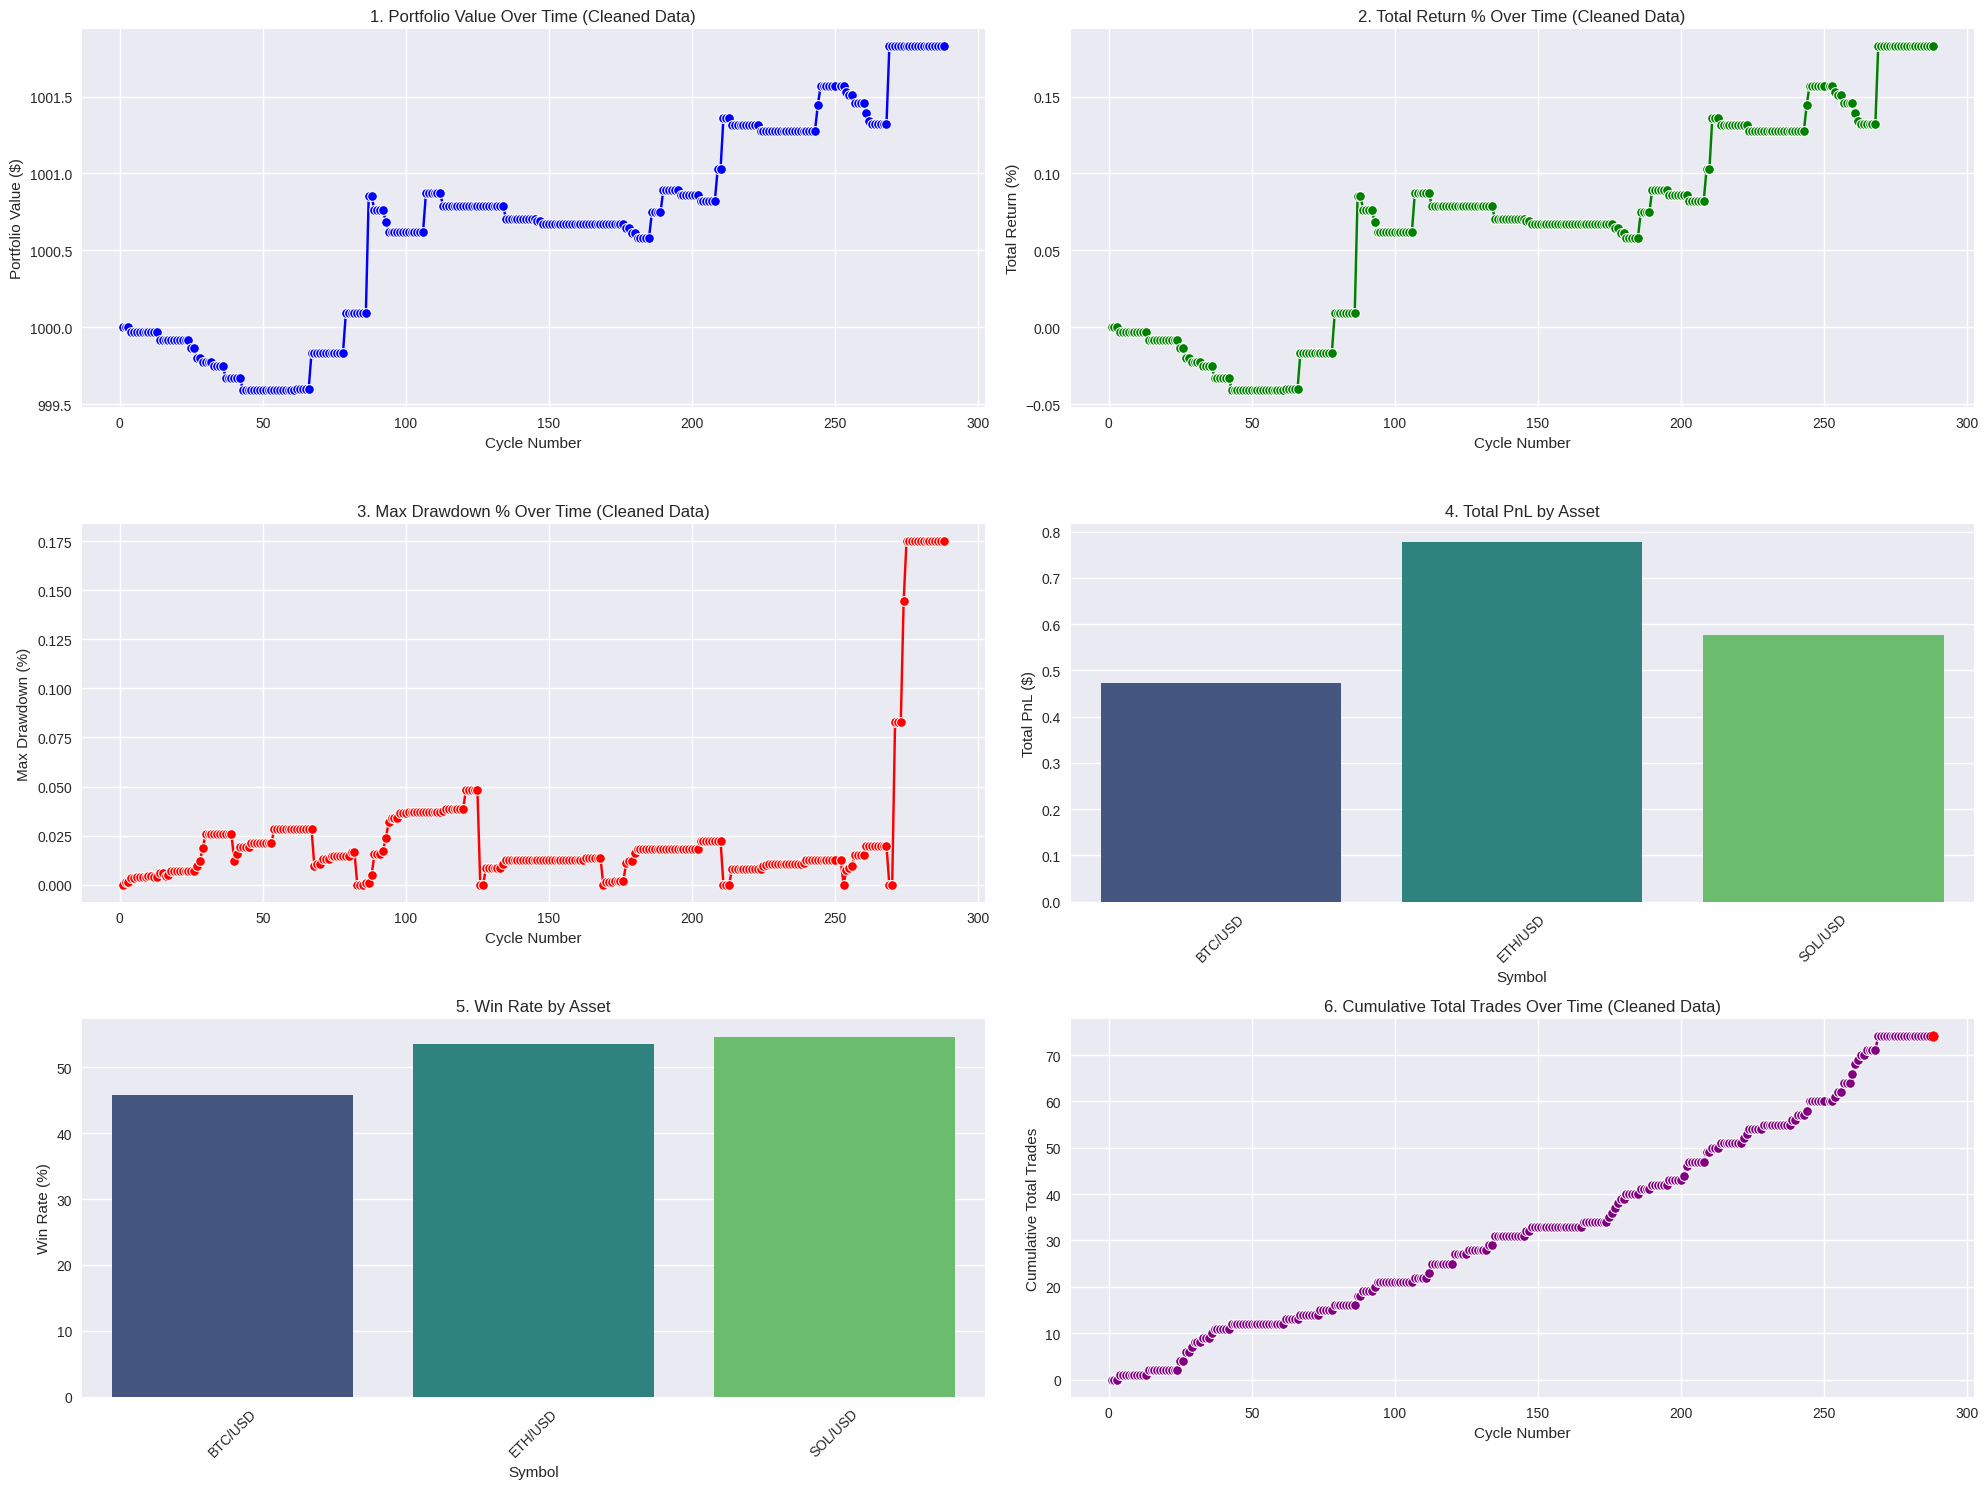

In [ ]:
####### important to read ###########################

##BTC - CNN-LSTM with dataset TRAIN:12.5Y
#### WFO RESULTS - 2.3 years historical-data 2023-2025 WITH TUNER-HYPERBAND

#--- Aggregate Performance ---
#Average Out-of-Sample Sharpe Ratio: 6.08
#Total Compounded Return: 1842.32%
#Worst Out-of-Sample Max Drawdown: 30.14%
#Total Trades: 510


## ETH - CNN-LSTM with dataset TRAIN:9.5Y
#### WFO RESULTS - 2.3 years historical-data 2023-2025 WITH TUNER-HYPERBAND

#--- Aggregate Performance ---
#Average Out-of-Sample Sharpe Ratio: 6.20
#Total Compounded Return: 1757.69%
#Worst Out-of-Sample Max Drawdown: 30.39%
#Total Trades: 432


##SOL -  CNN-LSTM with dataset TRAIN:3.5Y
#### WFO RESULTS - 2.3 years historical-data 2023-2025 WITH TUNER-HYPERBAND

#--- Aggregate Performance ---
#Average Out-of-Sample Sharpe Ratio: 5.10
#Total Compounded Return: 1185.53%
#Worst Out-of-Sample Max Drawdown: 32.68%
#Total Trades: 430

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore') # Suppress Matplotlib/Seaborn warnings for cleaner output

# --- CONFIGURATION ---
DB_PATH = '/content/gdrive/MyDrive/TradingBotLogs/trading_bot.db'
PLOT_DIR = '/content/gdrive/MyDrive/TradingBotLogs/plots/'
os.makedirs(PLOT_DIR, exist_ok=True)
# ---------------------

def get_cycle_performance_data(db_path, start_cycle=None, end_cycle=None, days=None):
    """
    Loads cycle performance data, applying filters for data cleanliness and
    excluding misleading high-value cycles.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_path)

        query = """
        SELECT
            cycle_number,
            timestamp,
            portfolio_value,
            total_return_pct,
            max_drawdown_pct,
            sharpe_ratio,
            total_trades,
            winning_trades,
            total_pnl,
            runtime_hours
        FROM cycle_performance
        WHERE 1=1
        """
        params = []

        # CRITICAL FILTER: Exclude cycles where portfolio value is unrealistic (i.e., old test runs).
        query += " AND portfolio_value < 5000.00"

        if start_cycle is not None:
            query += " AND cycle_number >= ?"
            params.append(start_cycle)
        if end_cycle is not None:
            query += " AND cycle_number <= ?"
            params.append(end_cycle)
        if days is not None:
            query += " AND datetime(timestamp) >= datetime('now', ?)"
            params.append(f'-{days} days')
        query += " ORDER BY cycle_number"

        df = pd.read_sql_query(query, conn, params=params, dtype={'timestamp': str, 'total_trades': float})

        # 1. Timestamp Conversion and cleanup
        if 'timestamp' in df.columns:
            # Use format='mixed' and errors='coerce' to handle varied/out-of-bounds timestamps
            df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', errors='coerce')
            # Drop rows with corrupted timestamps (now NaT)
            df.dropna(subset=['timestamp'], inplace=True)

        # 2. Calculate 'cumulative_trades'
        if 'total_trades' in df.columns:
            # Fill NaN values with 0 and convert to integer for cumsum/plotting
            df['total_trades'] = df['total_trades'].fillna(0).astype(int)
            df['cumulative_trades'] = df['total_trades'].cumsum()

        return df

    except sqlite3.Error as e:
        # Re-raise error to be caught by the main execution block
        raise sqlite3.Error(f"Query Execution Error on cycle_performance: {e}")
    finally:
        if conn:
            conn.close()


def get_asset_performance_summary(db_path, days=None, symbols=None):
    """
    Generates summary of per-asset performance, filtered by realistic portfolio value.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_path)
        # Query joins asset data with cycle data to filter by portfolio_value
        query = """
        SELECT
            asset_cycle_performance.symbol,
            asset_cycle_performance.pnl,
            asset_cycle_performance.trades,
            cycle_performance.cycle_number,
            cycle_performance.portfolio_value
        FROM asset_cycle_performance
        JOIN cycle_performance ON asset_cycle_performance.cycle_number = cycle_performance.cycle_number
        WHERE cycle_performance.portfolio_value < 5000.00
        """

        # Add optional time filter parameters
        params = []
        if days is not None:
            query += " AND datetime(cycle_performance.timestamp) >= datetime('now', ?)"
            params.append(f'-{days} days')

        asset_df = pd.read_sql_query(query, conn, params=params)

        # Aggregate the clean data
        summary_df = asset_df.groupby('symbol').agg(
            total_trades=('trades', 'sum'),
            total_pnl=('pnl', 'sum'),
            avg_pnl=('pnl', 'mean'),
            winning_trades=('pnl', lambda x: (x > 0).sum())
        ).reset_index()

        if not summary_df.empty:
            summary_df['win_rate'] = (summary_df['winning_trades'] / summary_df['total_trades']) * 100

        return summary_df.fillna(0)

    except sqlite3.Error as e:
        raise sqlite3.Error(f"Query Execution Error on asset_cycle_performance: {e}")
    finally:
        if conn:
            conn.close()


def create_performance_charts(cycle_df, asset_df):
    """Generate and save the visual performance charts (6-panel report)."""
    os.makedirs(PLOT_DIR, exist_ok=True)
    try:
        plt.style.use('seaborn-v0_8')
    except:
        plt.style.use('default')

    if cycle_df.empty or len(cycle_df) < 2:
        print("⚠️ Insufficient cycle performance data for multi-charts.")
        return

    plt.figure(figsize=(20, 15))

    # 1. Portfolio Value Over Time
    plt.subplot(3, 2, 1)
    sns.lineplot(data=cycle_df, x='cycle_number', y='portfolio_value', marker='o', color='blue')
    plt.title('1. Portfolio Value Over Time (Cleaned Data)')
    plt.xlabel('Cycle Number')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True)

    # 2. Total Return %
    plt.subplot(3, 2, 2)
    sns.lineplot(data=cycle_df, x='cycle_number', y='total_return_pct', marker='o', color='green')
    plt.title('2. Total Return % Over Time (Cleaned Data)')
    plt.xlabel('Cycle Number')
    plt.ylabel('Total Return (%)')
    plt.grid(True)

    # 3. Max Drawdown %
    plt.subplot(3, 2, 3)
    sns.lineplot(data=cycle_df, x='cycle_number', y='max_drawdown_pct', marker='o', color='red')
    plt.title('3. Max Drawdown % Over Time (Cleaned Data)')
    plt.xlabel('Cycle Number')
    plt.ylabel('Max Drawdown (%)')
    plt.grid(True)

    # 4. Asset PnL Bar Chart
    plt.subplot(3, 2, 4)
    if not asset_df.empty:
        sns.barplot(data=asset_df, x='symbol', y='total_pnl', hue='symbol', palette='viridis', legend=False)
        plt.title('4. Total PnL by Asset')
        plt.xlabel('Symbol')
        plt.ylabel('Total PnL ($)')
        plt.xticks(rotation=45)
        plt.grid(True, axis='y')
    else:
        plt.text(0.5, 0.5, 'No asset data', ha='center', va='center')
        plt.title('4. Total PnL by Asset')

    # 5. Win Rate by Asset
    plt.subplot(3, 2, 5)
    if not asset_df.empty:
        sns.barplot(data=asset_df, x='symbol', y='win_rate', hue='symbol', palette='viridis', legend=False)
        plt.title('5. Win Rate by Asset')
        plt.xlabel('Symbol')
        plt.ylabel('Win Rate (%)')
        plt.xticks(rotation=45)
        plt.grid(True, axis='y')
    else:
        plt.text(0.5, 0.5, 'No asset data', ha='center', va='center')
        plt.title('5. Win Rate by Asset')

    # 6. Cumulative Trades Over Time
    plt.subplot(3, 2, 6)
    sns.lineplot(data=cycle_df, x='cycle_number', y='cumulative_trades', marker='o', color='purple')
    plt.scatter(cycle_df['cycle_number'].iloc[-1], cycle_df['cumulative_trades'].iloc[-1], color='red', zorder=5)
    plt.title('6. Cumulative Total Trades Over Time (Cleaned Data)')
    plt.xlabel('Cycle Number')
    plt.ylabel('Cumulative Total Trades')
    plt.grid(True)


    plt.tight_layout()
    plot_path = os.path.join(PLOT_DIR, f'performance_charts_filtered.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"📈 All Charts saved to {plot_path}")


def print_detailed_report(cycle_df, asset_df):
    """Prints detailed performance report to console using pre-filtered data."""
    if cycle_df.empty:
        print("⚠️ No cycle data available after filtering.")
        return

    report = {
        'timestamp': datetime.now(),
        'cycle_summary': cycle_df.to_dict('records'),
        'asset_summary': asset_df.to_dict('records'),
        'recommendations': []
    }

    # --- Generate Recommendations ---
    latest_cycle = cycle_df.iloc[-1]

    # Recommendations based on Cycle Summary
    if latest_cycle['max_drawdown_pct'] > 10:
        report['recommendations'].append(
            f"🔻 High drawdown ({latest_cycle['max_drawdown_pct']:.2f}%) in cycle {latest_cycle['cycle_number']} - review risk parameters"
        )
    if latest_cycle['sharpe_ratio'] < 1:
        report['recommendations'].append(
            f"⚠️ Low Sharpe Ratio ({latest_cycle['sharpe_ratio']:.2f}) in cycle {latest_cycle['cycle_number']} - assess volatility"
        )
    if latest_cycle['total_return_pct'] > 20:
        report['recommendations'].append(
            f"✅ Strong return ({latest_cycle['total_return_pct']:.2f}%) in cycle {latest_cycle['cycle_number']} - consider scaling"
        )

    # Recommendations based on Asset Summary
    for asset in report['asset_summary']:
        if asset['total_trades'] < 5:
            report['recommendations'].append(
                f"⏳ {asset['symbol']}: Limited trades ({asset['total_trades']}) - collect more data"
            )
        elif asset['win_rate'] < 40:
            report['recommendations'].append(
                f"🔻 {asset['symbol']}: Low win rate ({asset['win_rate']:.1f}%) - review trading strategy"
            )
        if asset['total_pnl'] < 0:
            report['recommendations'].append(
                f"🔻 {asset['symbol']}: Negative PnL (${asset['total_pnl']:,.2f}) - check model performance"
            )
        if asset['win_rate'] > 60 and asset['total_pnl'] > 0:
            report['recommendations'].append(
                f"🎯 {asset['symbol']}: Strong performer (Win Rate: {asset['win_rate']:.1f}%, PnL: ${asset['total_pnl']:,.2f}) - consider scaling"
            )

    # --- Print to Console ---
    print(f"\n{'📊 PERFORMANCE ANALYSIS REPORT (CLEAN DATA) ':═^80}")
    print(f"Generated: {report['timestamp']}")
    print(f"{'':═^80}")

    print(f"\n{'📈 CYCLE PERFORMANCE SUMMARY (HEAD/TAIL) ':─^80}")
    print("Head (First 5 Cycles):")
    print(cycle_df[['cycle_number', 'timestamp', 'portfolio_value', 'total_return_pct',
                    'max_drawdown_pct', 'sharpe_ratio', 'total_trades', 'winning_trades', 'total_pnl', 'runtime_hours']].head().to_string(index=False))
    print("\nTail (Last 5 Cycles):")
    print(cycle_df[['cycle_number', 'timestamp', 'portfolio_value', 'total_return_pct',
                    'max_drawdown_pct', 'sharpe_ratio', 'total_trades', 'winning_trades', 'total_pnl', 'runtime_hours']].tail().to_string(index=False))

    print(f"\n{'📈 AGGREGATE ASSET PERFORMANCE SUMMARY ':─^80}")
    print(asset_df[['symbol', 'total_trades', 'winning_trades', 'win_rate', 'total_pnl', 'avg_pnl']].to_string(index=False))

    print(f"\n{'🎯 RECOMMENDATIONS ':─^80}")
    for rec in report['recommendations']:
        print(f"   {rec}")
    if not report['recommendations']:
        print("   ✅ No major issues detected")
    print(f"{'':═^80}\n")

    print(f"Total Cycles in Report: {len(cycle_df)}")
    print(f"Total Trades in Report: {cycle_df['total_trades'].sum()}")
    print("--- End of Console Report ---")

# ----------------------------------------------------------------------
# --- MAIN EXECUTION BLOCK (Combines Data Loading and Reporting) ---
try:
    print(f"Attempting to load data from: {DB_PATH} with portfolio filter...")

    # Load all cycle data and asset data using the filter
    cycle_df = get_cycle_performance_data(DB_PATH)
    asset_df = get_asset_performance_summary(DB_PATH)

    if not cycle_df.empty:
        # Print the detailed console report (as requested)
        print_detailed_report(cycle_df, asset_df)

        # Generate and save all charts
        create_performance_charts(cycle_df, asset_df)

    else:
        print("🛑 Plotting aborted: Dataframe is empty due to data loading failure.")
except sqlite3.Error as e:
    print(f"\n❌ CRITICAL DATABASE ERROR: Could not complete reporting.")
    print(f"Reason: {e}")
except Exception as e:
    print(f"\n💥 Critical execution error: {e}")